### このノートはMEM後のデータに対して, PCAとentropy計算による解析を行うためのものです. 

このノートに関しては, 基本は最初の行でgoogle driveをマウントして, あとはパスだけ入れればすべての行を実行で解析できるはずです.  
## (注意) 現状, Igor上でimchi3_dataを2次元に直して (最新版Data_preprocessing.ipfが必要), csv書き出ししないと解析できません. この点に関しても将来的には解消する予定 (それよりもmatlab実装したほうがよいでしょうか？) 

---
#### To do 
1. .ibwそのまま読み込み
2. クラスタ数の自動決定 (G-means?)
3. z stackデータへの対応
4. PCAのみの解析

PCA 参考ページ https://qiita.com/NoriakiOshita/items/460247bb57c22973a5f0  
k-means 参考ページ https://aiacademy.jp/media/?p=254  
Google colab参考ページ　https://pyhoo.jp/google-colaboratory-manual


### 最初にgoogle driveをマウントします　　
カーソルを下の文字列のどこかにおいて, shift + enterを押してください.  

リンクをクリックするとログインを求められるので, そちらで表示される文字列をコピーしてください. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


基本的には最初の行に, 必要事項を入力して, あとはshift + Enterで進めていけば解析が可能です. 

---
### パス文字列の取得法を以下に示します

1. マウントが終わったら左のファイルボタンをクリックします.

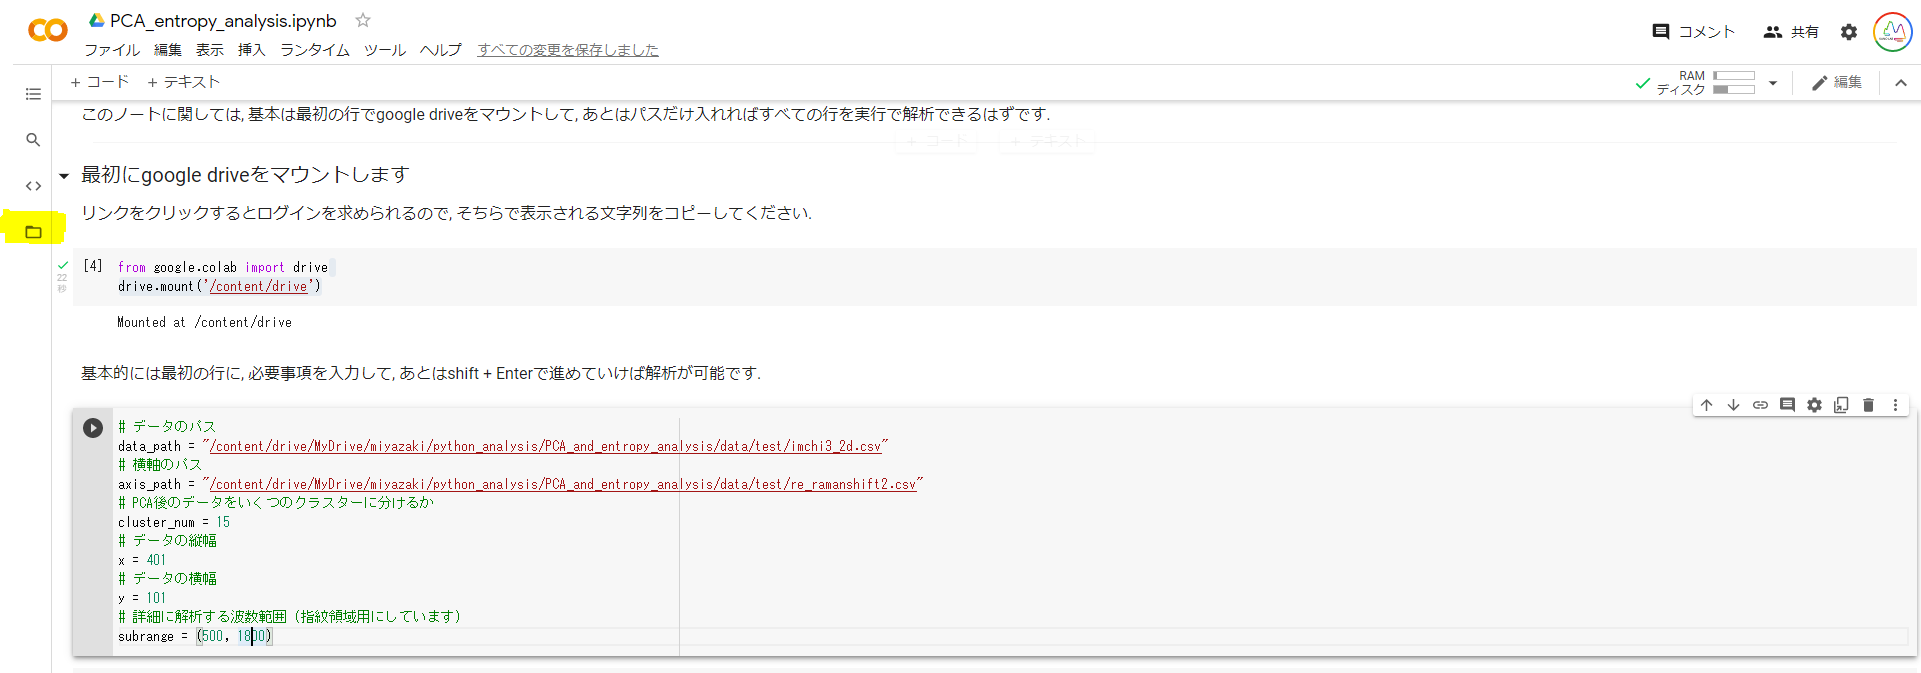

2. 以下のように左側にフォルダ一覧が出てきます. 解析したいファイル (MEM後のデータと横軸) が入っているフォルダまで開きます. 

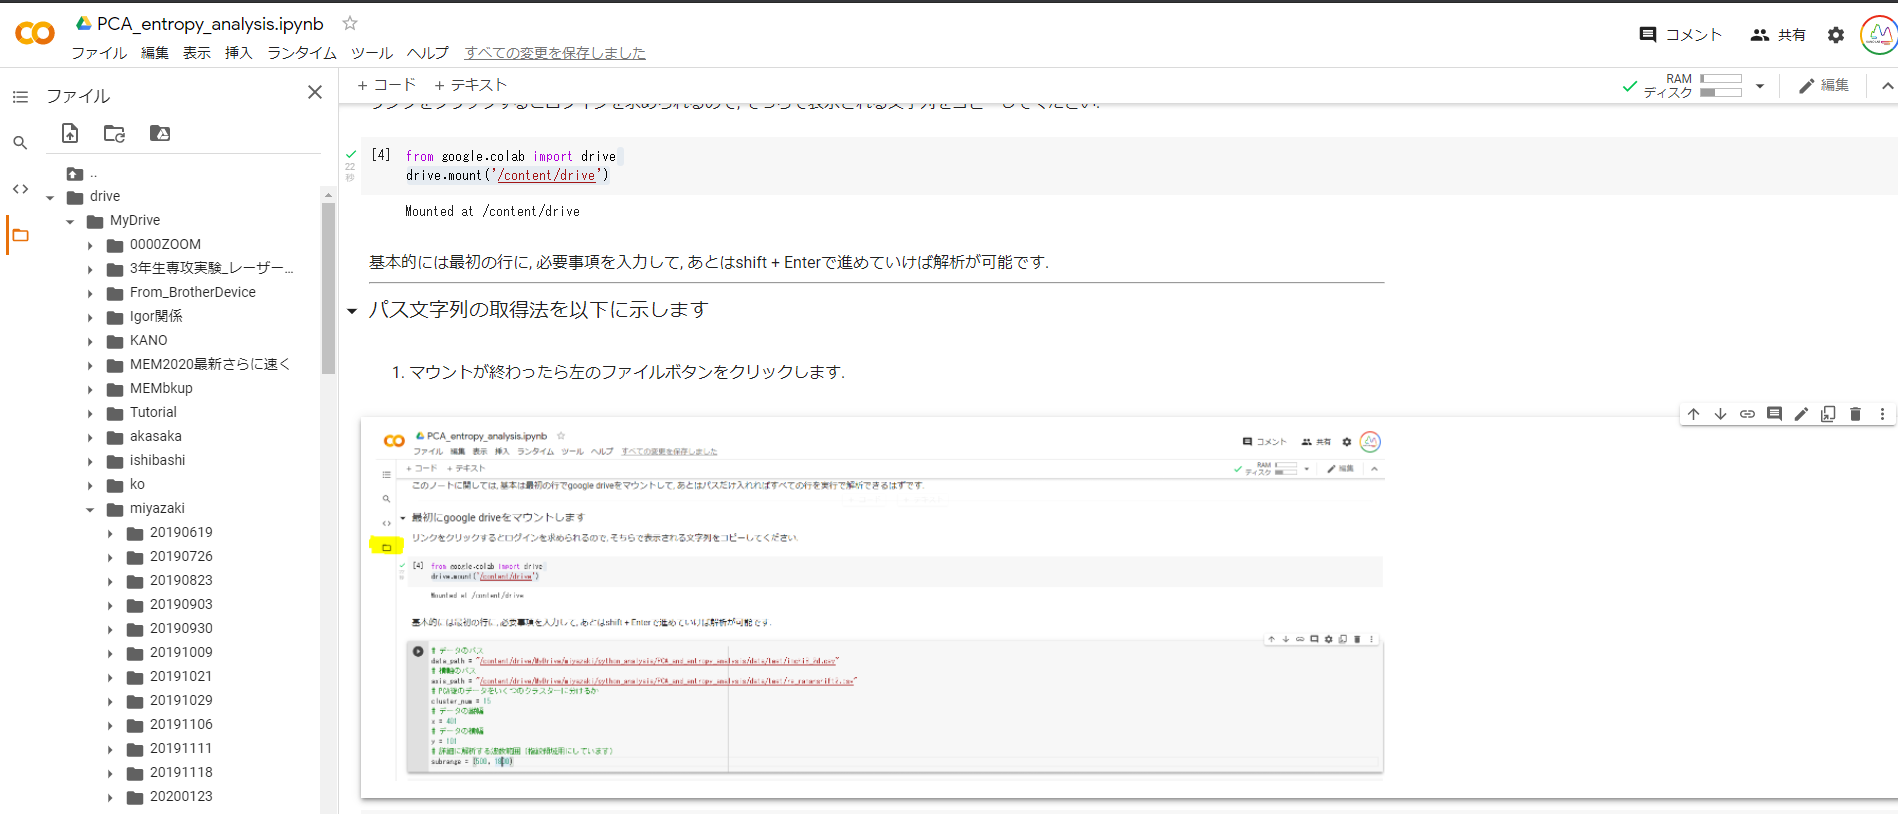

3. 解析したいファイルが見つかったら, そのファイルの名前の右側の〇ポチを押してパスをコピーというところをクリックします. 

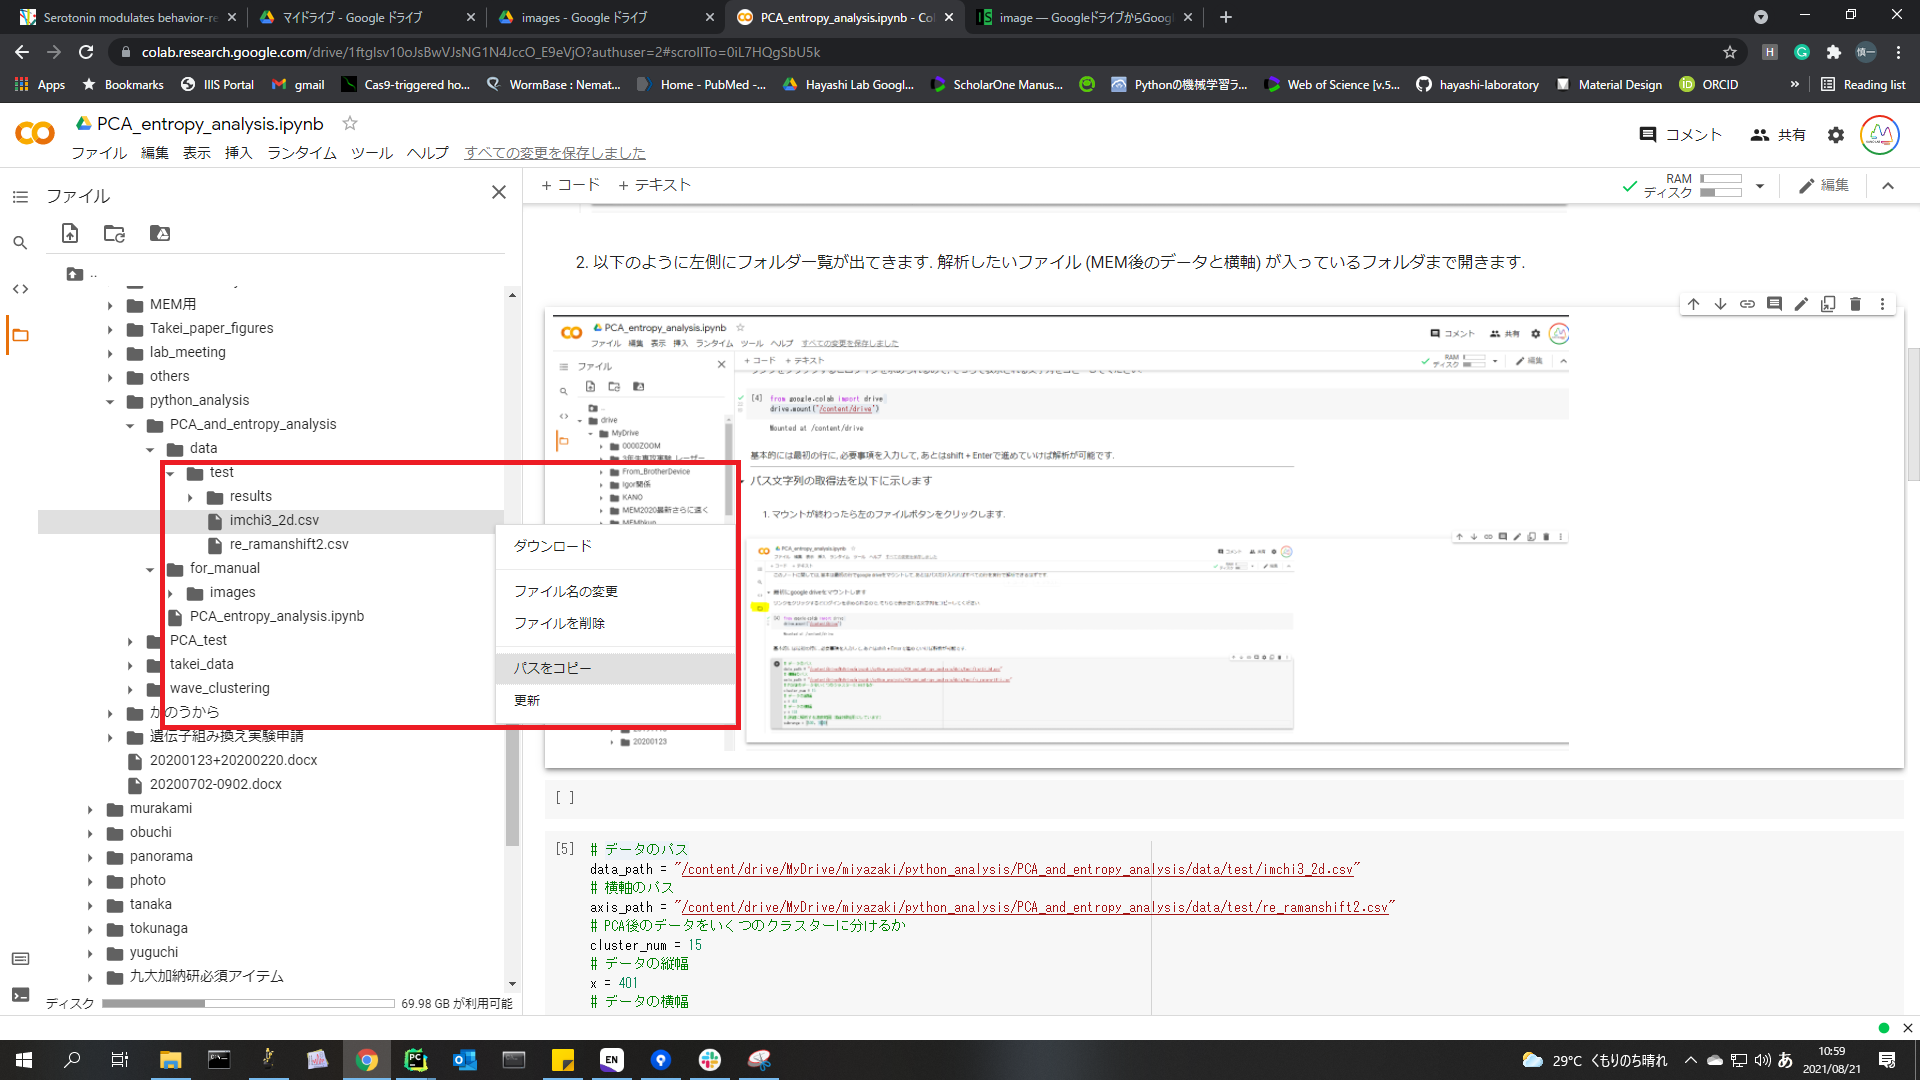

### この時点で, データパスが取得できているので, これ以降の行でパスを入れるところに入れてください. 横軸についても同様にしてください. 

あとは基本的にはすべて実行で大丈夫です.  
ctrl+F9でもいいですし, このページの上のほうにある"ランタイム/すべてのセルを実行"でもいいですし, shift + Enter連打でも大丈夫です.  


最後の行に少し時間がかかります. 101*401のデータで2分くらいでしょうか.  
終わったら, google drive内に結果フォルダを作ってくれていますので, そちらからダウンロードしていただければと思います. 

# パスとその他のパラメータを入れてください

In [2]:
# データのパス
data_path = "/content/drive/MyDrive/murakami/20211027/brainslice/imchi3_2d.csv"
axis_path = "/content/drive/MyDrive/murakami/20211027/brainslice/re_ramanshift2.csv"
# PCA後のデータをいくつのクラスターに分けるか
cluster_num = 5
# データの縦幅
x = 501
# データの横幅
y = 681
# 詳細に解析する波数範囲 (指紋領域用にしています)
subrange = (600,1800)

In [3]:
# moduleのインポート
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans

In [4]:
def normalization(data_array):
    """
    normalize the data array within 0~255
    :param data_array: numpy array 
    :return: data_array: numpy array (overwrite)
    """
    amin = np.amin(data_array)
    amax = np.amax(data_array)
    scale = 255.0 / (amax - amin)
    data_array = data_array - amin
    data_array = data_array * scale
    data_array = np.uint8(data_array)
    return data_array

def calc_entropy(tempdata):
    """
    :param tempdata: numpy array
    :return: entropy: float32, entropy value (shannon's entropy) of input array
    """
    tempdata = tempdata.values
    histgram = [0] * 256
    # normalization
    tempdata = normalization(tempdata)

    for i in range(len(tempdata)):
        histgram[tempdata[i]] += 1
    entropy = 0
    for i in range(256):
        p = histgram[i] / len(tempdata)
        if p == 0:
            continue
        entropy -= p * math.log2(p)
    return entropy

def Entropy_analysis(data, x_axis, flag):
    """
    calculate entropy values of input 2D wave (wavenum*xyz)
    make line plot (x: wavenum, y: entropy)
    make df 

    :param data: numpy array
    :param x_axis: numpy array 
    :param flag: tag for analysis, full means full length of data (500-3500)

    :return None 
    """

    entropy_values = []
    for i in range(len(data.T)):
        tempdata = data[i]
        entropy_values.append(calc_entropy(tempdata))
    entropy_df = pd.DataFrame([x_axis, entropy_values])
    # draw fig
    fig, ax = plt.subplots()
    ax.grid(False)
    ax.invert_xaxis()
    ax.plot(x_axis, entropy_values, color="black")
    # save
    plt.savefig("./results/figures/entropy_plot_{}.png".format(flag),
                transparent=True, bbox_inches="tight", pad_inches=0.1)
    entropy_df.to_csv("./results/entropy_df_{}.csv".format(flag))


def PCA_analysis(data, x_axis, flag):
    # data normalization
    norm_data = data.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
    pca = PCA()
    pca.fit(norm_data)
    feature = pca.transform(norm_data)
    data_PCA = pd.DataFrame(feature,
                            columns=["PC{}".format(x + 1) for x in range(len(norm_data.columns))])

    # make graph for PC scatter
    os.makedirs("./results/figures", exist_ok=True)
    plt.figure(figsize=(6, 6))
    plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, color="black")
    plt.grid()
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(False)
    plt.savefig("./results/figures/PCA_scatter_{}.png".format(flag), transparent=True)

    # make graph for CDF
    plt.figure(figsize=(8, 5))
    pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(norm_data.columns))])
    plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-o",
             color="black")
    plt.xlabel("Number of principal components")
    plt.ylabel("Cumulative contribution rate")
    plt.grid()
    plt.xlim(0, 15)
    plt.grid(False)
    plt.savefig("./results/figures/PCA_CDF_{}.png".format(flag), transparent=True, bbox_inches="tight", pad_inches=0.1)

    # clustering and
    extracted_df = data_PCA#.iloc[:, 0:cluster_num]
    cust_array = extracted_df.to_numpy()
    cust_array = cust_array
    pred = KMeans(n_clusters=cluster_num).fit_predict(cust_array)
    pred_image = np.reshape(pred, [x, y])
    plt.imsave('./results/figures/clustered_img_{}.png'.format(flag), pred_image)

    # class differentiation
    os.makedirs("./results/spectrum_{}".format(flag), exist_ok=True)
    os.makedirs("./results/figures/Class_images_{}".format(flag), exist_ok=True)
    Class_list = []
    for i in range(cluster_num):
        Class_list.append(np.where(pred != i, 0, 1))
        plt.imsave("./results/figures/Class_images_{0}/Class{1}.png".format(flag, i),
                   np.reshape(np.where(pred != i,0,1), [x, y]))

    for i in range(cluster_num):
        fig, ax = plt.subplots()
        Class_data = data.T * Class_list[i]
        Class_data = np.mean(Class_data.T.values, axis = 0)
        Class_min = np.min(Class_data)
        Class_max = np.max(Class_data)
        norm_Class_data = (Class_data - Class_min)/(Class_max - Class_min)
        ax.set_ylim([-0.2, 1])
        ax.grid(False)
        ax.invert_xaxis()
        ax.plot(x_axis, norm_Class_data, color="black")
        plt.savefig("./results/spectrum_{0}/norm_Class_{1}.png".format(flag, i),
                    transparent=True, bbox_inches="tight", pad_inches=0.1)
        
        fig, ax = plt.subplots()
        ax.set_ylim([-0.2, 1])
        ax.grid(False)
        ax.invert_xaxis()
        ax.plot(x_axis, Class_data, color="black")
        plt.savefig("./results/spectrum_{0}/Class_{1}.png".format(flag, i),
                    transparent=True, bbox_inches="tight", pad_inches=0.1)
        
        pd.DataFrame(Class_data).to_csv("./results/spectrum_{0}/Class_{1}.csv".format(flag,i))

def execute_analysis(data_path, axis_path):
  os.chdir(os.path.dirname(data_path))
  # all range analysis
  data = pd.read_csv(data_path, header=None).T[0:x*y]
  x_axis = np.loadtxt(axis_path)
  PCA_analysis(data, x_axis, flag = "full")
  #Entropy_analysis(data, x_axis, flag = "full")

  # subrange analysis 
  #subrange_axis = x_axis[np.where((x_axis>subrange[0])&(x_axis<subrange[1]))]
  #subrange_data = data.T.iloc[np.where((x_axis>subrange[0])&(x_axis<subrange[1]))].T
  #PCA_analysis(subrange_data, subrange_axis, flag = "subrange")
  #Entropy_analysis(data, x_axis, flag = "subrange")

In [ ]:
execute_analysis(data_path, axis_path)